## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mick/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

/Users/mick/anaconda/envs/ee227-py3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# This loads the file that you want, might take several seconds (up to a minute)

with open("news_sentiment.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[1040])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{'person': 'Bashar al-Assad',
                    'text': 'President',
                    'wdid': 'Q44329'},
                   {'person': 'Emile Hokayem', 'text': 'in Foreign Policy'},
                   {'person': 'Ahrar al Sham',
                    'text': 'the most important groups',
                    'wdid': 'Q860943'},
                   {'person': 'Vladimir Putin',
                    'text': 'Russian President',
                    'wdid': 'Q7747'},
                   {'person': 'Barack Obama',
                    'text': 'U.S. President',
                    'wdid': 'Q76'},
                   {'person': 'Osama Abu Zeid',
                    'text': 'a senior adviser to the moderate Free Syrian '
                            'Army'},
                   {'person': 'Op-Ed',
                    'text': 'for The Washington Post',
                    'wdid': 'Q2602337'},
                  

In [12]:
pprint(articles[40])


{b'news_topic': b'ISIS War',
 'introductions': [{'person': 'Ismail Kahraman',
                    'sentiment': 0.0,
                    'source': 'france24.com',
                    'text': 'parliament speaker',
                    'wdid': 'Q6043452'},
                   {'person': 'Ismail Kahraman',
                    'sentiment': 0.0,
                    'source': 'france24.com',
                    'text': 'who stirred controversy in April when he proposed '
                            'a religious constitution',
                    'wdid': 'Q6043452'},
                   {'person': 'Levent Gok',
                    'sentiment': 0.4019,
                    'source': 'france24.com',
                    'text': 'the secular CHP party representative',
                    'wdid': 'Q6027977'}],
 'pubtime': datetime.datetime(2016, 5, 20, 10, 5, 25),
 'source': 'france24.com',
 'title': 'Turkey parliament votes on contentious immunity bill',
 'url': 'http://www.france24.com/en/20160520-tu

In [4]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [5]:
# get only articles from one story, you can change this
articles = ISIS_articles

## Extract introductions, and obtain their sentiment

In [6]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    intro['sentiment'] = analyzer.polarity_scores(intro['text'])['compound']

In [7]:
len(total_introductions)

214880

In [8]:
total_introductions[0]

{'person': 'Vladimir Putin',
 'sentiment': 0.0,
 'source': 'nytimes.com',
 'text': 'President'}

In [9]:
%load_ext autoreload
%autoreload 2


In [10]:
from Featurizer import Featurizer

[nltk_data] Downloading package stopwords to /Users/mick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
featurizer_fitler = Featurizer()
count_person = featurizer_fitler.counter_global('person', total_introductions)
text_one_hot_filter = featurizer_fitler.fit_text_one_hot(total_introductions)[0]

kept_introductions = []   
for i in tqdm.tqdm_notebook(range(len(total_introductions))):
    intro = total_introductions[i]
    person = intro['person']
    if count_person[person] < 3:
        continue
    if np.sum(text_one_hot_filter[i]) < 1:
        continue
    kept_introductions.append(intro)

print("Total mentions", len(kept_introductions))


Total mentions 63158


In [32]:
count_person2 = featurizer_fitler.counter_global('person', kept_introductions2)


In [33]:
len(count_person2)

5932

In [31]:
featurizer = Featurizer()
text_one_hot, text_feats = featurizer.fit_text_one_hot(kept_introductions)
source_one_hot, source_feats = featurizer.fit_source_one_hot(kept_introductions)
person_one_hot, person_feats = featurizer.fit_person_one_hot(kept_introductions)

print(text_one_hot.shape, source_one_hot.shape, person_one_hot.shape)
assert text_one_hot.shape[0] == source_one_hot.shape[0]
assert source_one_hot.shape[0] == person_one_hot.shape[0]

(178183, 1013) (178183, 22) (178183, 7140)


In [34]:
kept_introductions[0]

{'person': 'Vladimir Putin',
 'sentiment': 0.0,
 'source': 'nytimes.com',
 'text': 'President'}

In [ ]:
X = np.array([intro['dat'].toarray() for intro in kept_introductions])

In [ ]:
X.shape

## PCA 

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=10, svd_solver='full')
pca_one_hot = pca.fit_transform(text_one_hot)                 

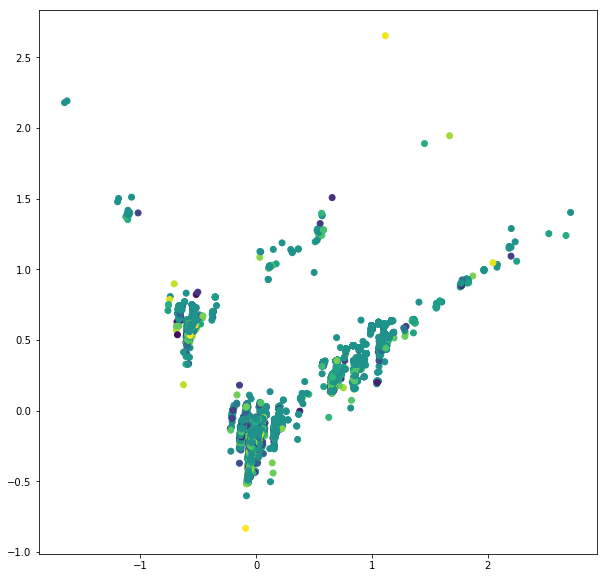

In [237]:
plt.scatter(pca_one_hot[:,0],pca_one_hot[:,1], c=Y_sentiments)
plt.show()

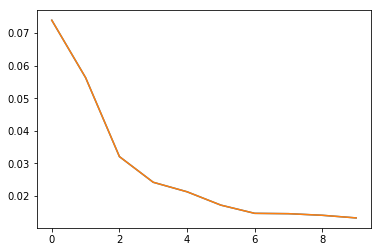

In [26]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [27]:
reduced_text = pca_one_hot[:,:7]

In [28]:
def examine_feature_weight(weights, feature_names, show=20):
    contribution = [(i,v) for i,v in enumerate(weights)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 *abs(c[1]))
    for i in range(show):
        c = ranked_contrib[i]
        print(np.around(c[1], decimals=3), feature_names[c[0]])
        

In [29]:
proj = pca.transform(np.eye(1013))
examine_feature_weight(np.sum(proj,axis=1), featurizer.text_count_v.get_feature_names())

-2.133 syria
-1.032 envoy
0.942 minist
-0.657 leader
-0.642 special
-0.603 unit
-0.599 arab
-0.597 nation
0.561 foreign
-0.556 leagu
-0.55 ambassador
-0.545 group
-0.542 turkish
-0.541 iraq
-0.537 islam
-0.495 base
-0.494 head
0.492 spokesman
-0.49 turkey
0.49 mr


In [ ]:
small_intro = np.array(kept_introductions)[small_idx]

In [ ]:
groups = [group0, group1, group2]
for i in range(3):
    print("Group", i)
    print("------")
    sub_intro = small_intro[groups[i]]
    for j in range(20):
        this_intro = sub_intro[j]
        print("person: ", sub_intro[j]['person'])
        print("text: ", sub_intro[j]['text'])
        print("source: ", sub_intro[j]['source'])
        print("sentiment: ", sub_intro[j]['sentiment'])
        print("---")


## CCA

In [37]:
def print_shapes(list_arr):
    for a in list_arr:
        print(a.shape)

def pack_sentiments(intro):
    

{'person': 'Ibrahim Kalin',
 'sentiment': -0.077056674993935648,
 'source': 'aljazeera.com',
 'text': 'presidential spokesman',
 'wdid': 'Q15440590'}

In [46]:
Y_sentiments = np.array([intro['sentiment'] for intro in kept_introductions])
X_cca = np.hstack([source_one_hot, person_one_hot, reduced_text])
cca_feats = source_feats + person_feats + ['reduced_pca' for i in range(reduced_text.shape[1])]

text_one_hot, text_feats = featurizer.fit_text_one_hot(kept_introductions)
source_one_hot, source_feats = featurizer.fit_source_one_hot(kept_introductions)
person_one_hot, person_feats = featurizer.fit_person_one_hot(kept_introductions)


print_shapes([X_cca, Y_sentiments])
assert len(cca_feats) == X_cca.shape[1]

In [42]:
print_shapes([X_cca, Y_sentiments])

(178183, 7169)
(178183,)


In [ ]:
# non_zero_Y_idx = Y_sentiments != 0
# pos_sen_idx = Y_sentiments > 0
# neg_sen_idx = Y_sentiments < 0

# X_pos, Y_pos = X[pos_sen_idx], Y_sentiments[pos_sen_idx]
# X_neg, Y_neg = X[neg_sen_idx], Y_sentiments[neg_sen_idx]

# X_pos.shape, Y_pos.shape
# X_neg.shape, Y_neg.shape

In [44]:
small_idx = np.random.choice(np.arange(0, X_cca.shape[0]), 10000)
small_X_cca = X_cca[small_idx]
small_Y_cca = Y_sentiments[small_idx]

In [45]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
cca.fit(small_X_cca, small_Y_cca)


CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [47]:
examine_feature_weight(cca.coef_, cca_feats)

[-1.098] Kayla
[ 1.032] Gunness
[-1.012] Marcou
[-0.975] Douglas
[-0.914] Zahidullah
[-0.909] Kantar
[ 0.906] al-Mohaisany
[ 0.896] al-Ali
[ 0.87] DAVIS
[ 0.86] Coons
[-0.851] Christopher
[-0.843] Burak
[-0.836] Yucel
[ 0.792] RUSI
[-0.792] Zoroastrianism
[-0.784] al-Numani
[-0.78] al-Noman
[ 0.773] BDP
[-0.751] Talbisseh
[ 0.748] al-Ghaith


In [54]:
X_projected = cca.transform(kept_introductions)

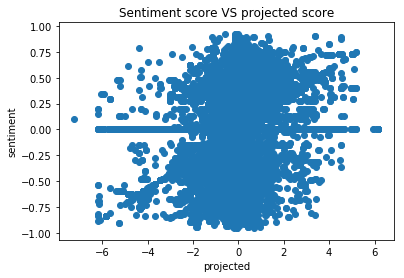

In [57]:
import matplotlib.pyplot as plt
plt.scatter(-1*x_proj[:,0], small_Y_cca)
plt.title("Sentiment score VS projected score")
plt.xlabel("projected")
plt.ylabel("sentiment")
plt.show()

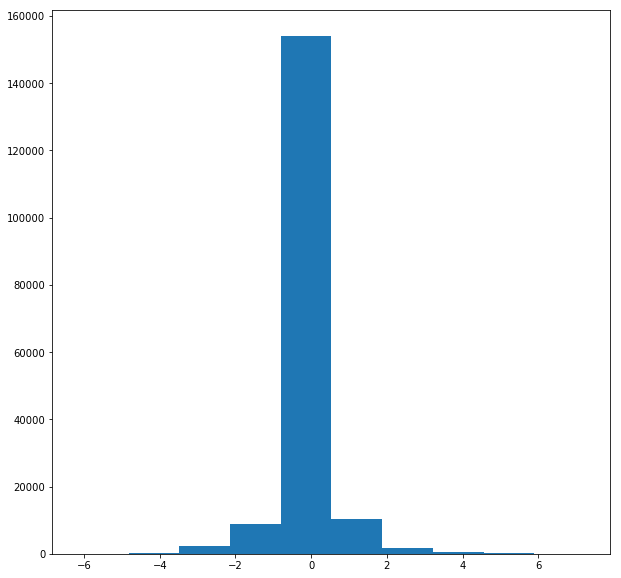

In [164]:
plt.hist(X_projected[:,0])
plt.show()
plt.t

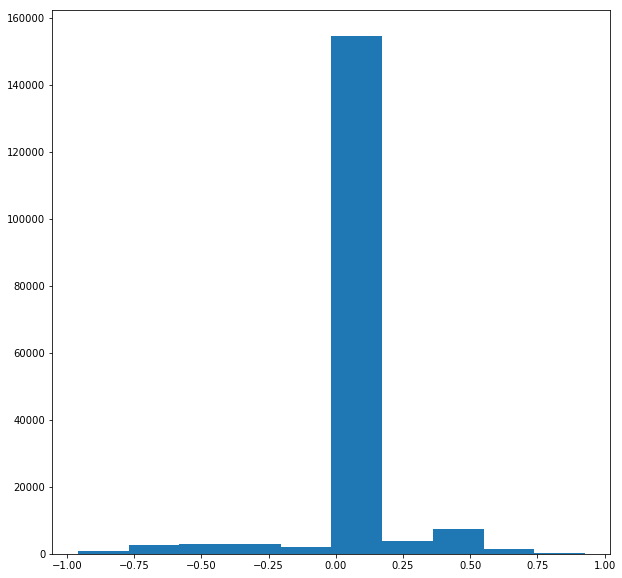

In [165]:
plt.hist(Y_sentiments)
plt.show()

In [ ]:
# one hot statistics:
count_all_one_hots = np.sum(X_train_counts, axis=1)
print("Max count: ", np.max(count_all_one_hots))
print("Max count: ", np.min(count_all_one_hots))
print("Min count: ", np.mean(count_all_one_hots))

import matplotlib.pyplot as plt
from matplotlib import colors
plt.hist(count_all_one_hots, bins=100)
plt.title("Word count histogram")
plt.xlabel("word count")
plt.ylabel("mentions")
plt.show()

In [58]:
for i in range(len(kept_introductions)):
    kept_introductions[i]['sentiment'] = X_projected[i][0]

In [60]:

total_introductions = kept_introductions

In [152]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 100)
for intro in subsample:
    if intro['sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])


---------------
Entity mentionned: Erdogan
Turkey 's
Sentiment: -0.00506674016781
---------------
Entity mentionned: Erdogan
who had stated that he saw no difference between the justice marchers and the putschists who gunned down civilians during last July 's coup attempt
Sentiment: 0.156769549963
---------------
Entity mentionned: Agatha Christie
crime writer
Sentiment: 0.155914760801
---------------
Entity mentionned: Kofi Annan
international envoy
Sentiment: -0.635042636716
---------------
Entity mentionned: Abu Risha
Al - Baghdadiya TV
Sentiment: 0.563549261154
---------------
Entity mentionned: Ahmet Davutoglu
Foreign Minister
Sentiment: -0.0375849117584
---------------
Entity mentionned: Trump
who is to take office in January
Sentiment: -0.00803365024049
---------------
Entity mentionned: Al Akhbar
Lebanese daily
Sentiment: 0.0769837601959
---------------
Entity mentionned: Philip Hammond
Foreign Secretary
Sentiment: -0.224517496591
---------------
Entity mentionned: Bashar al-As

## Build a 2-dimensional object containing sentiment per entity, per source

In [153]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['sentiment'])

In [154]:
# An example of how one entity (a city) is described by different sources

print(ent_source_sent['Aleppo'])

{'bbc.co.uk': [0.31446620883343168, 0.31159884779992403, 0.31431872236219571, 0.31132895293238105, 0.3121256700739109, 0.31431872236219571, 0.31506239423664656, 0.31197152702126407, 0.31197152702126407, 0.31132895293238105, 0.31474387183061947, 0.31197152702126407, 0.31431872236219571, 0.31166223389236064, 0.3125788776402274, 0.3125788776402274, 0.31132895293238105, 0.31132895293238105, 0.31132895293238105, 0.31773772118685722, 0.31132895293238105, 0.31132895293238105, 0.31132895293238105, 0.31431872236219571, 0.31132895293238105, 0.31132895293238105, 0.31197152702126407], 'cnn.com': [0.27216267446281373, 0.27231976098340388, 0.27750065424775389, 0.27360350781420639, 0.27186782710345531, 0.27186782710345531, 0.27251040119233833, 0.27528274600169372, 0.27251040119233833, 0.27228930201909046, 0.27213772197099828, 0.2717321921868659, 0.27251040119233833, 0.27186782710345531, 0.25179168030499605, 0.24907301984973546, 0.28062271691179358, 0.27468907350848443, 0.27216267446281373, 0.27261031

In [155]:
# We get rid of entities that don't contain enough data

entities_kept = []

for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 6715  /  7682 in our dataset
We have  22 sources:  ['washingtonpost.com', 'businessinsider.in', 'aljazeera.com', 'wikinews.org', 'techcrunch.com', 'middleeasteye.net', 'france24.com', 'foxnews.com', 'reuters.com', 'bbc.co.uk', 'allafrica.com', 'ap.org', 'theguardian.com', 'bloomberg.com', 'aa.com.tr', 'rt.com', 'nytimes.com', 'independent.co.uk', 'chinadaily.com.cn', 'telegraph.co.uk', 'cnn.com', 'latimes.com']


## We create the array we will use in our sparse model

In [238]:
# Parameters: changing these affects the results you get
Pos_neg_ratio = 2.0
overall_ratio = 0.15
pos_threshold = 0.01
neg_threshold = -0.01

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        N_pos = float(len(np.where(sent_array > pos_threshold)[0]))
        N_neg = float(len(np.where(sent_array < neg_threshold)[0]))
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        A[i,j] = aggregate_sentiment
        
        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({1: 14806, -1: 7746, 0: 846})


## Model source similarity

In [239]:
# Write code that uses this matrix (entities, sources) to compute
# source similarity visible in bias of the way they describe entities

In [240]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A)

In [241]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.12)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(sources[i], sources[j])

middleeasteye.net aljazeera.com
france24.com washingtonpost.com
france24.com aljazeera.com
france24.com middleeasteye.net
foxnews.com washingtonpost.com
foxnews.com aljazeera.com
foxnews.com france24.com
reuters.com washingtonpost.com
reuters.com aljazeera.com
reuters.com middleeasteye.net
reuters.com france24.com
reuters.com foxnews.com
bbc.co.uk washingtonpost.com
bbc.co.uk aljazeera.com
bbc.co.uk middleeasteye.net
bbc.co.uk france24.com
bbc.co.uk reuters.com
ap.org aljazeera.com
ap.org middleeasteye.net
ap.org foxnews.com
theguardian.com aljazeera.com
theguardian.com middleeasteye.net
theguardian.com foxnews.com
theguardian.com bbc.co.uk
theguardian.com ap.org
bloomberg.com aljazeera.com
bloomberg.com middleeasteye.net
bloomberg.com france24.com
bloomberg.com foxnews.com
bloomberg.com reuters.com
bloomberg.com theguardian.com
aa.com.tr aljazeera.com
aa.com.tr middleeasteye.net
aa.com.tr france24.com
aa.com.tr foxnews.com
aa.com.tr reuters.com
aa.com.tr ap.org
aa.com.tr theguardian.c

## Workspace

In [242]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

0.1


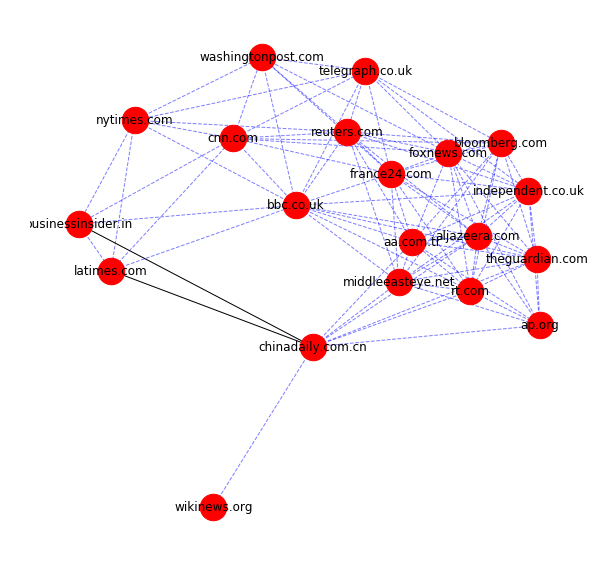

0.2


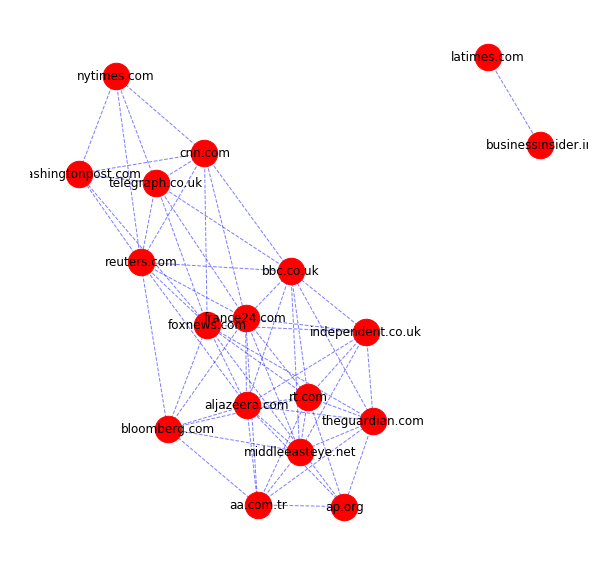

0.3


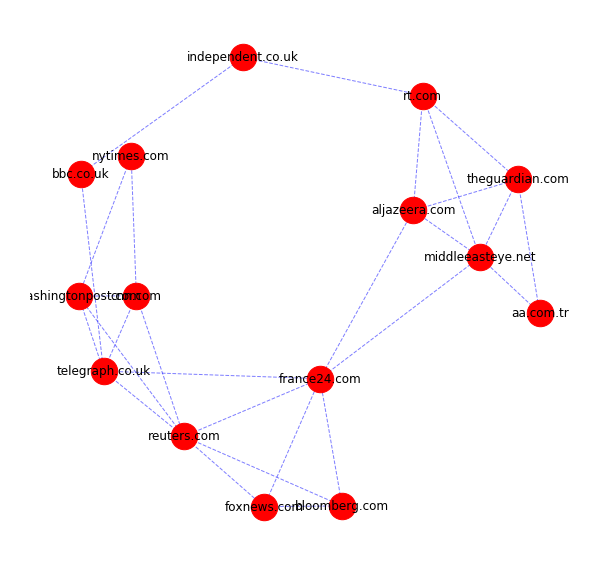

0.4


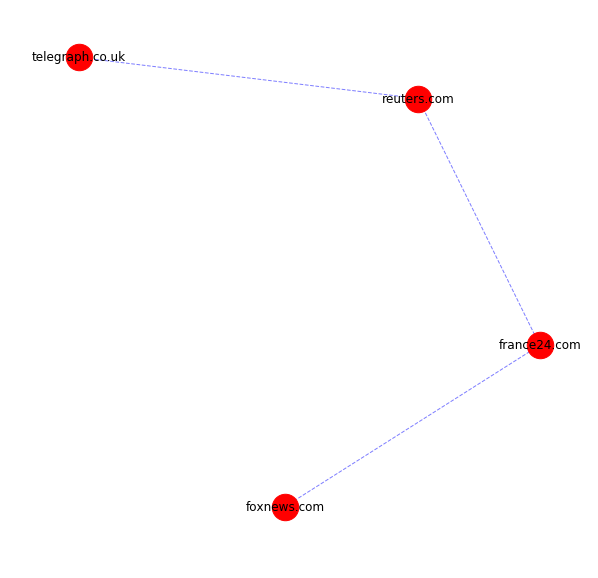

In [244]:
for i in np.arange(0.1,0.5, 0.1):
    l1_lambda = i
    print(l1_lambda)
    graph_lasso = GraphLasso(alpha=l1_lambda)
    graph_lasso.fit(A_std)
    plot_network(graph_lasso.get_precision(), sources)

In [245]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

0.1


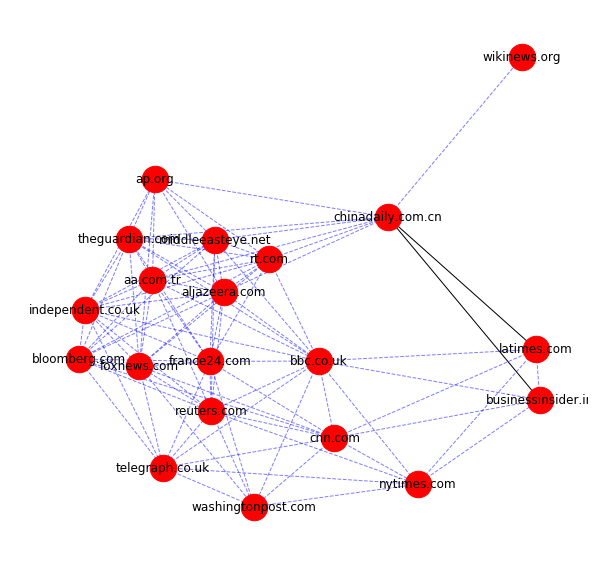

0.2


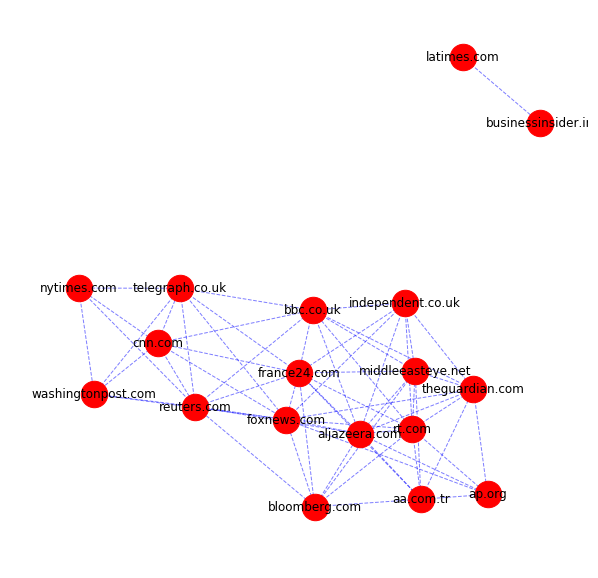

0.3


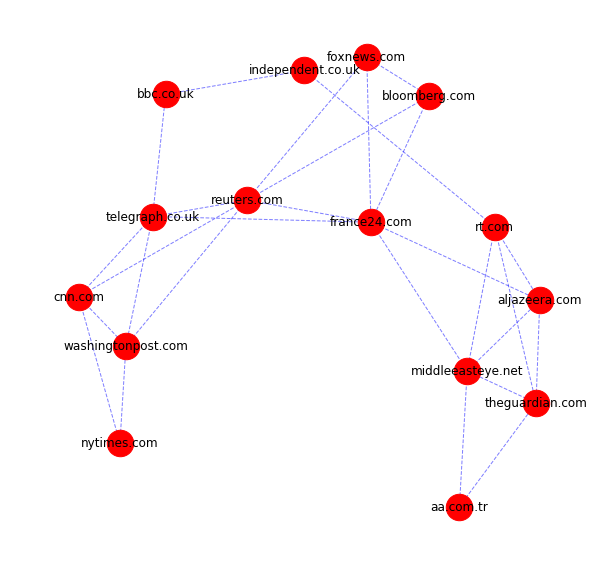

0.4


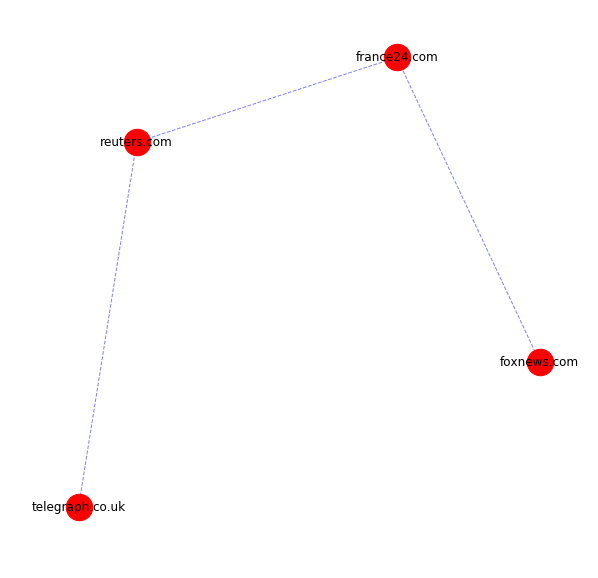

In [246]:
for i in np.arange(0.1,0.5, 0.1):
    l1_lambda = i
    print(l1_lambda)
    plot_network(my_graphical_lasso(A_std, l1_lambda), sources)

## Our Glasso: best by inspection

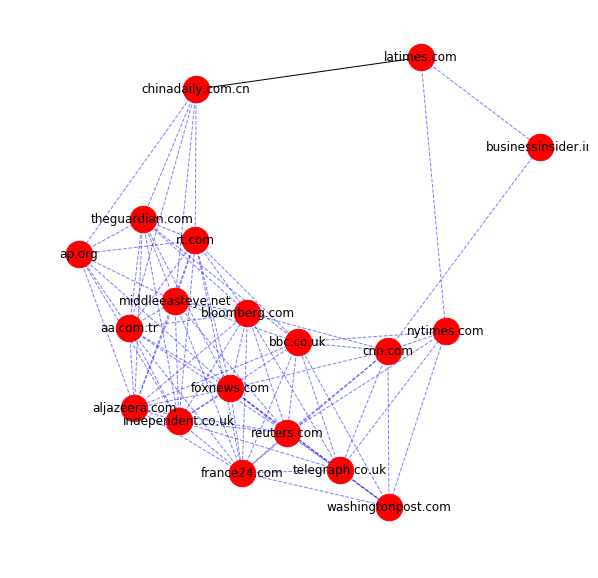

In [247]:
plot_network(my_graphical_lasso(A_std, l1_lambda=0.12), sources)

## Neighborhood method

In [248]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso

In [249]:
n_sel = NGraphSelection(Lasso)
g = n_sel.fit(A_std, 0.10, 'AND')

0.1


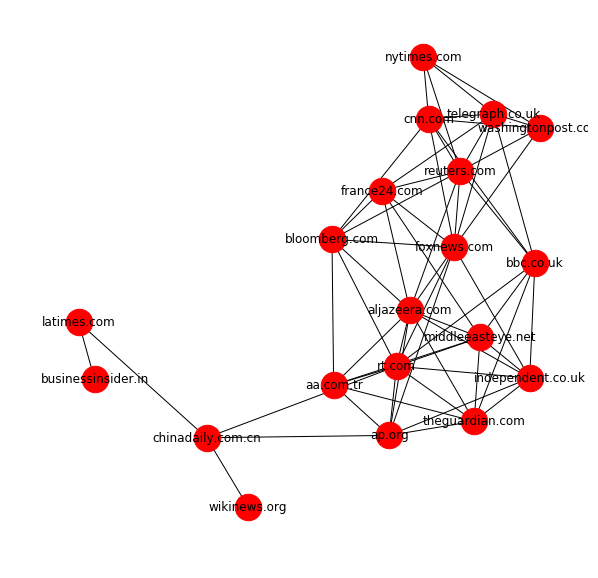

0.2


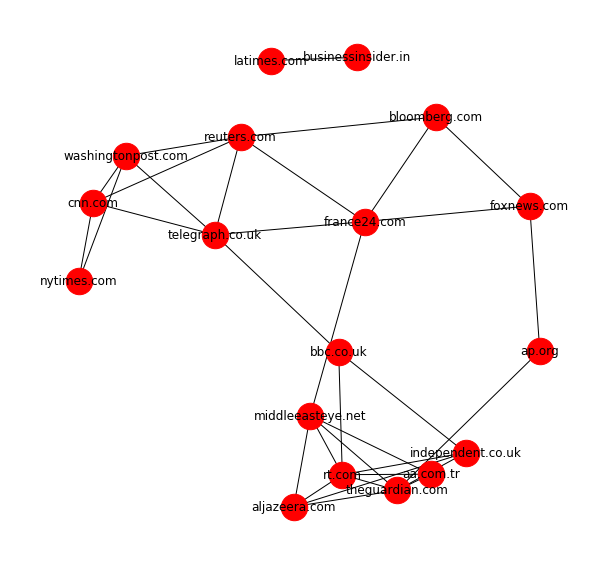

0.3


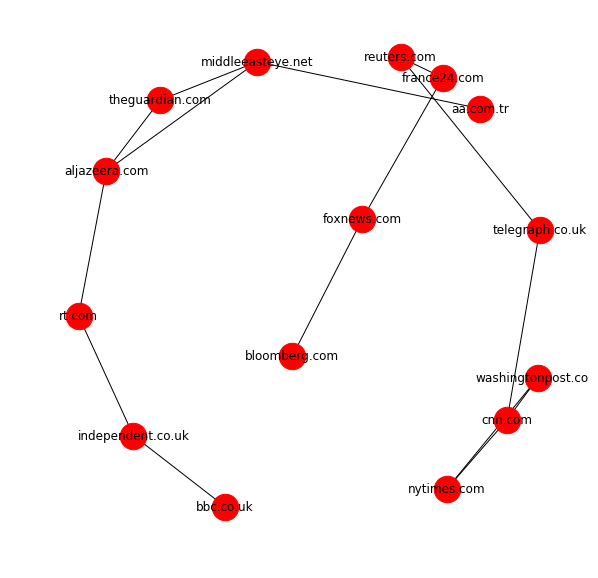

0.4


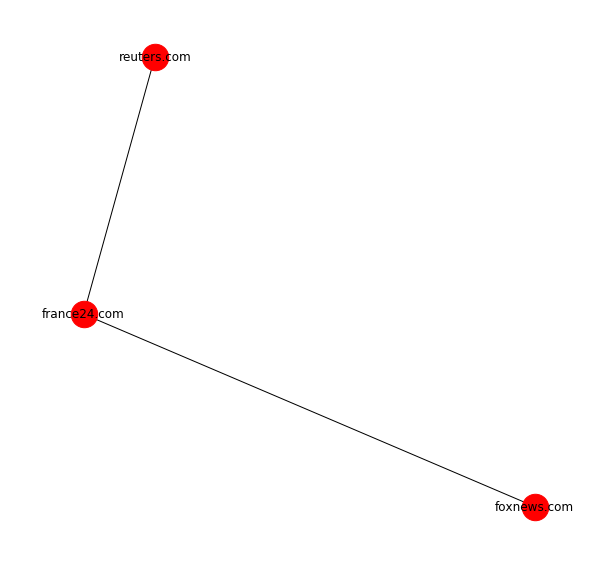

In [251]:
for i in np.arange(0.1,0.5, 0.1):
    l1_lambda = i
    print(l1_lambda)
    plot_network(n_sel.fit(A_std, l1_lambda, 'AND'), sources)

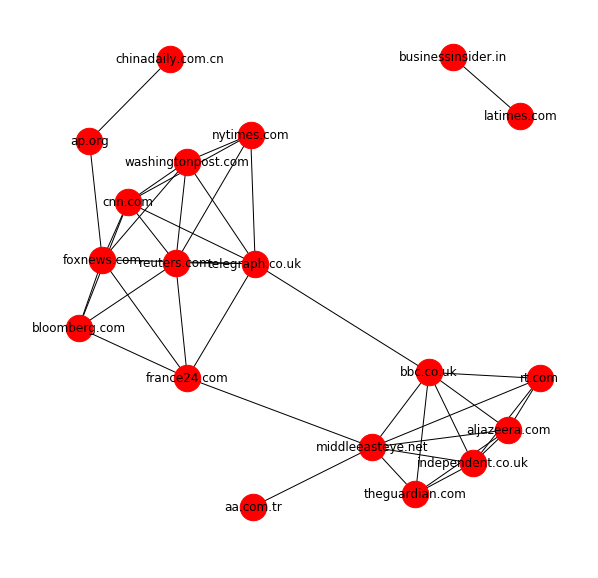

In [235]:
plot_network(n_sel.fit(A_std, 0.2, 'AND'), sources)